In [ ]:
from glob import glob
import pandas as pd
import os

# Get list of filtered comparison files (just the base filenames, without extension)
files = glob("./processed_raw/*.png")
file_basenames = set([os.path.splitext(os.path.basename(f))[0].replace("","").replace("_comparison","") for f in files])

# Paths to CSVs
intensity_path = "./csv/intensity_processed.csv"
cell_count_path = "./csv/results.csv"

# Read CSVs
intensity_df = pd.read_csv(intensity_path)
cell_count_df = pd.read_csv(cell_count_path)
print(cell_count_df.head()), print(intensity_df.head())

                                    filename  blob_count
0  NvACE2_Stitched[GFP 469,525]_F7_12hpi.png         582
1  PaACE2_Stitched[GFP 469,525]_E6_12hpi.png         482
2  NvACE2_Stitched[GFP 469,525]_G2_12hpi.png         635
3   hACE2_Stitched[GFP 469,525]_B7_24hpi.png         927
4  PaACE2_Stitched[GFP 469,525]_G3_12hpi.png         382
                                    filename  normalized_intensity_sum  width  \
0   hACE2_Stitched[GFP 469,525]_C4_72hpi.png              1.606153e+09   3740   
1  NvACE2_Stitched[GFP 469,525]_G9_24hpi.png              1.827413e+08   3752   
2  NvACE2_Stitched[GFP 469,525]_E8_12hpi.png              4.417873e+06   3754   
3  NvACE2_Stitched[GFP 469,525]_B2_12hpi.png              5.902039e+07   3755   
4  NvACE2_Stitched[GFP 469,525]_B6_48hpi.png              1.615844e+07   3759   

   height  channels  error  
0    3762         1    NaN  
1    3759         1    NaN  
2    3760         1    NaN  
3    3762         1    NaN  
4    3771         1    NaN

(None, None)

In [20]:
# Merge the two dataframes on a common column (assume 'filename' or similar)
# Try to find a column that matches the file basenames
def find_filename_column(df):
    for col in df.columns:
        if df[col].astype(str).str.contains("|".join(file_basenames)).any():
            return col
    return None


intensity_col = "filename"
cell_count_col = "filename"

if intensity_col is None or cell_count_col is None:
    raise ValueError("Could not find a filename column in one of the CSVs.")

# Merge on the filename columns (rename to a common name if needed)
intensity_df = intensity_df.rename(columns={intensity_col: "filename"})
cell_count_df = cell_count_df.rename(columns={cell_count_col: "filename"})

merged_df = pd.merge(intensity_df, cell_count_df, on="filename", how="inner")

# Filter merged_df to only include rows where the filename is in file_basenames
filtered_df = merged_df[
    merged_df["filename"].apply(
        lambda x: os.path.splitext(os.path.basename(str(x)))[0] in file_basenames
    )
]

filtered_df.head()

,filename,normalized_intensity_sum,width,height,channels,error,blob_count
0,"hACE2_Stitched[GFP 469,525]_C4_72hpi.png",1.606153e+09,3740,3762,1,NaN,67675
1,"NvACE2_Stitched[GFP 469,525]_G9_24hpi.png",1.827413e+08,3752,3759,1,NaN,12036
2,"NvACE2_Stitched[GFP 469,525]_E8_12hpi.png",4.417873e+06,3754,3760,1,NaN,661
3,"NvACE2_Stitched[GFP 469,525]_B2_12hpi.png",5.902039e+07,3755,3762,1,NaN,6346
4,"NvACE2_Stitched[GFP 469,525]_B6_48hpi.png",1.615844e+07,3759,3771,1,NaN,1188


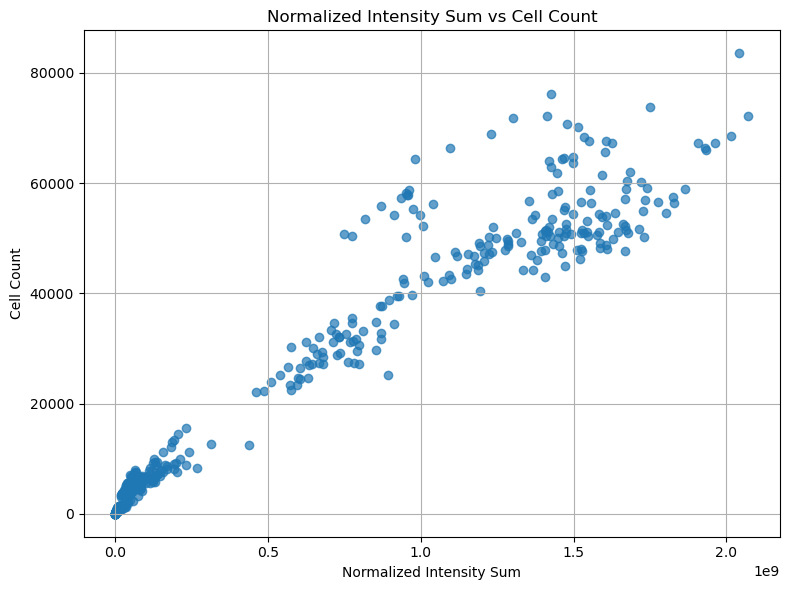

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(merged_df['normalized_intensity_sum'], merged_df['blob_count'], alpha=0.7)
plt.xlabel('Normalized Intensity Sum')
plt.ylabel('Cell Count')
plt.title('Normalized Intensity Sum vs Cell Count')
plt.grid(True)
plt.tight_layout()
plt.show()

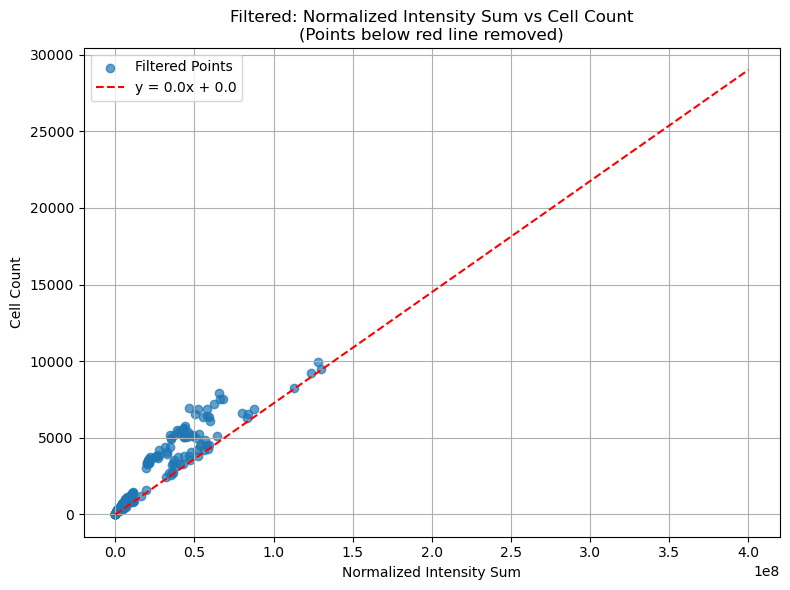

In [ ]:
import matplotlib.pyplot as plt

# Define the line: y = m*x + b, passing through (0,0) and (1e9,40000)
x1, y1 = 0, 0
x2, y2 = 4e8, 40000
m = (y2 - y1) / (x2 - x1)  # slope
b = y1 - m * x1            # intercept


# Filter: keep only points above or on the line
def above_line(row):
    x = row['normalized_intensity_sum']
    y = row['blob_count']
    # x-axis is normalized_intensity_sum, y-axis is cell_count
    # Only filter for x between 2 and 5 (inclusive), otherwise keep all points
    if x1 <= x <= x2:
        return y >= m * x + b
    else:
        return False

filtered_above_line_df = merged_df[merged_df.apply(above_line, axis=1)].copy()

# Plot the filtered points and the line
plt.figure(figsize=(8,6))
plt.scatter(
    filtered_above_line_df["normalized_intensity_sum"],
    filtered_above_line_df["blob_count"],
    alpha=0.7,
    label="Filtered Points",
)

# Plot the line from (2,0) to (5,20000)
line_x = [x1, x2]
line_y = [y1, y2]
plt.plot(line_x, line_y, color='red', linestyle='--', label='y = {:.1f}x + {:.1f}'.format(m, b))

plt.xlabel('Normalized Intensity Sum')
plt.ylabel('Cell Count')
plt.title('Filtered: Normalized Intensity Sum vs Cell Count\n(Points below red line removed)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



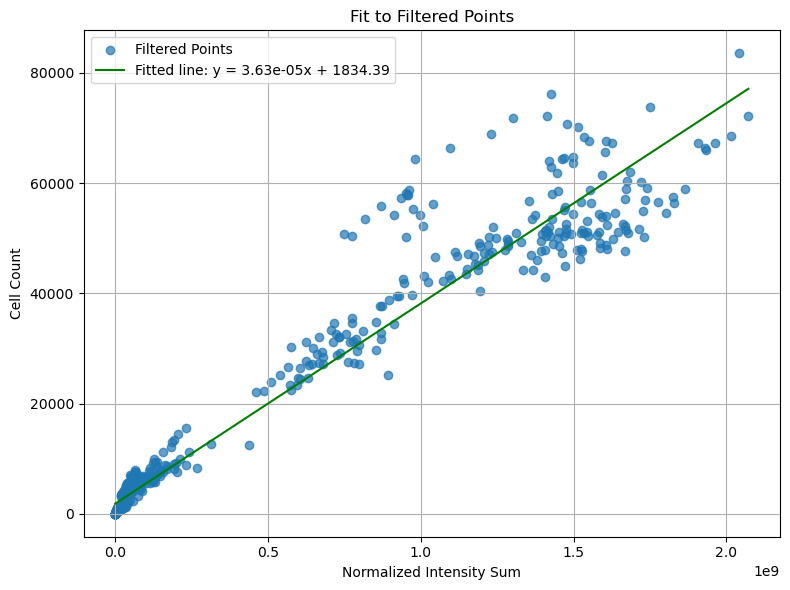

Fitted line: y = 3.63e-05 * x + 1834.39
R-squared: 0.9476


In [33]:
# Fit a line to the filtered points (normalized_intensity_sum vs cell_count)
from scipy.stats import linregress
import numpy as np

x = merged_df['normalized_intensity_sum']
y = merged_df['blob_count']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the filtered points and the fitted line
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.7, label='Filtered Points')

# Plot the fitted line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='green', linestyle='-', label='Fitted line: y = {:.2e}x + {:.2f}'.format(slope, intercept))

plt.xlabel('Normalized Intensity Sum')
plt.ylabel('Cell Count')
plt.title('Fit to Filtered Points')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Fitted line: y = {slope:.2e} * x + {intercept:.2f}")
print(f"R-squared: {r_value**2:.4f}")


In [ ]:
reprocess_csv = "./csv/intensity_reprocess.csv"
reprocess_df = pd.read_csv(reprocess_csv)
new_df = reprocess_df.copy()
new_df["blob_count"] = (slope * new_df["normalized_intensity_sum"] + intercept).astype(int)
new_df = new_df[["filename", "blob_count"]]
new_df.to_csv("results_reprocess.csv", index=False)

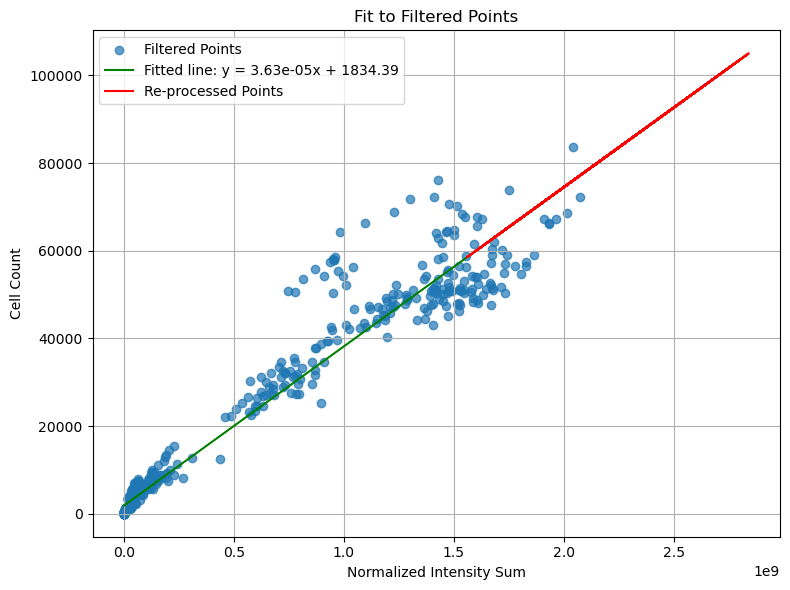

Fitted line: y = 3.63e-05 * x + 1834.39
R-squared: 0.9476


In [47]:
# Plot the filtered points and the fitted line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, label="Filtered Points")

# Plot the fitted line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(
    x_fit,
    y_fit,
    color="green",
    linestyle="-",
    label="Fitted line: y = {:.2e}x + {:.2f}".format(slope, intercept),
)

plt.plot(reprocess_df["normalized_intensity_sum"], new_df["blob_count"], color="red", linestyle="-", label="Re-processed Points")

plt.xlabel("Normalized Intensity Sum")
plt.ylabel("Cell Count")
plt.title("Fit to Filtered Points")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Fitted line: y = {slope:.2e} * x + {intercept:.2f}")
print(f"R-squared: {r_value**2:.4f}")


In [ ]:
# combine results.csv with results_reprocess.csv, overwriting rows with matching filenames with results_reprocess values
results_df = pd.read_csv("./csv/results.csv")
results_reprocess_df = pd.read_csv("./csv/results_reprocess.csv")

# set filename as index for easy update
results_df.set_index("filename", inplace=True)
results_reprocess_df.set_index("filename", inplace=True)

# update results_df with values from results_reprocess_df for overlapping filenames
results_df.update(results_reprocess_df)

# append new rows from results_reprocess_df that are not in results_df
combined_df = pd.concat([results_df, results_reprocess_df[~results_reprocess_df.index.isin(results_df.index)]])

# reset index and save
combined_df.reset_index(inplace=True)
combined_df.to_csv("./csv/results_combined.csv", index=False)